In [30]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/computer_vision_class/week5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow


#without denoising

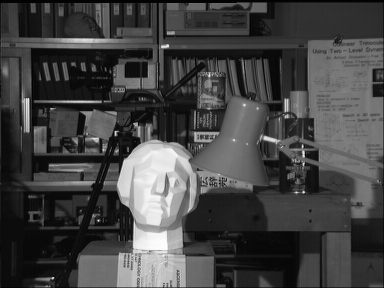

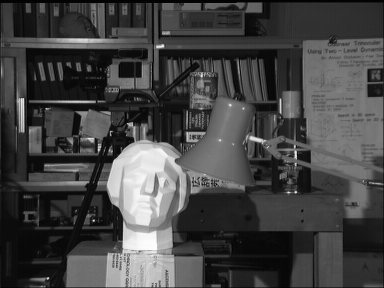

In [32]:

# read two input images as grayscale images
imgL = cv2.imread('L.png',0)
imgR = cv2.imread('R.png',0)

cv2_imshow(imgL)
cv2_imshow(imgR)



**cv2.StereoBM_create()** the disparity is computed by comparing the sum of absolute differences (SAD) of each 'block' of pixels




**numDisparities**	the disparity search range. For each pixel algorithm will find the best disparity from 0 (default minimum disparity) to numDisparities. The search range can then be shifted by changing the minimum disparity.


**blockSize**	the linear size of the blocks compared by the algorithm. The size should be odd (as the block is centered at the current pixel). Larger block size implies smoother, though less accurate disparity map. Smaller block size gives more detailed disparity map, but there is higher chance for algorithm to find a wrong correspondence.

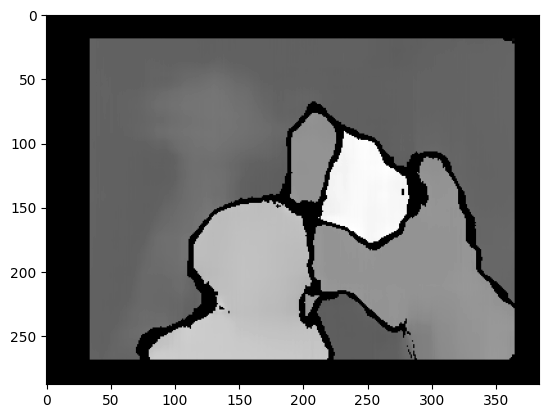

(288, 384)

In [38]:

# Initiate and StereoBM object
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=39)

# compute the disparity map
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()
disparity.shape

In [36]:
disparity

array([[-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       ...,
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16]], dtype=int16)

#using denoising algorithm

**cv.fastNlMeansDenoising()** - works with a single grayscale images
**cv.fastNlMeansDenoisingColored()** - works with a color image.

**h**: parameter deciding filter strength. Higher h value removes noise better, but removes details of image also. (10 is ok)
hForColorComponents : same as h, but for color images only. (normally same as h)



**templateWindowSize** : should be odd. (recommended 7)


**searchWindowSize** : should be odd. (recommended 21)

In [40]:
imgR = cv2.cvtColor(imgR, cv2.COLOR_GRAY2BGR)
imgL = cv2.cvtColor(imgL, cv2.COLOR_GRAY2BGR)


imgR = cv2.fastNlMeansDenoisingColored(imgR,None,3,3,7,21)
imgL = cv2.fastNlMeansDenoisingColored(imgL,None,3,3,7,21)


In [14]:
imgL.shape

(288, 384, 3)

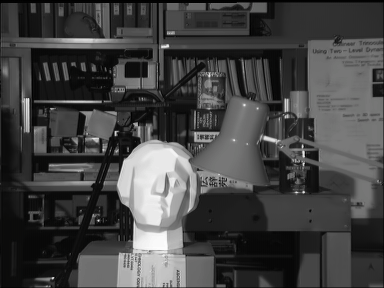

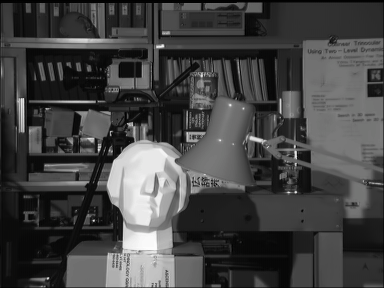

In [41]:

cv2_imshow(imgL)
cv2_imshow(imgR)


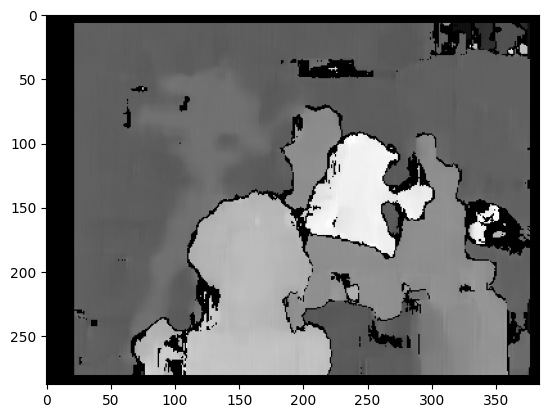

(288, 384)

In [43]:


# Initiate and StereoBM object
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

# compute the disparity map
disparity = stereo.compute(imgL[:,:,0],imgR[:,:,0])
plt.imshow(disparity,'gray')
plt.show()
disparity.shape

#sift and merging

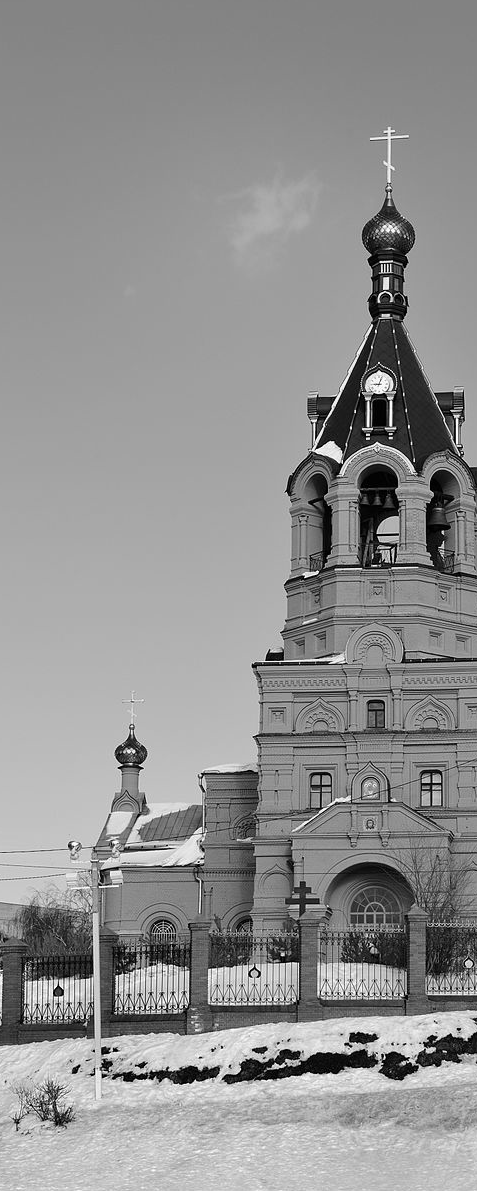

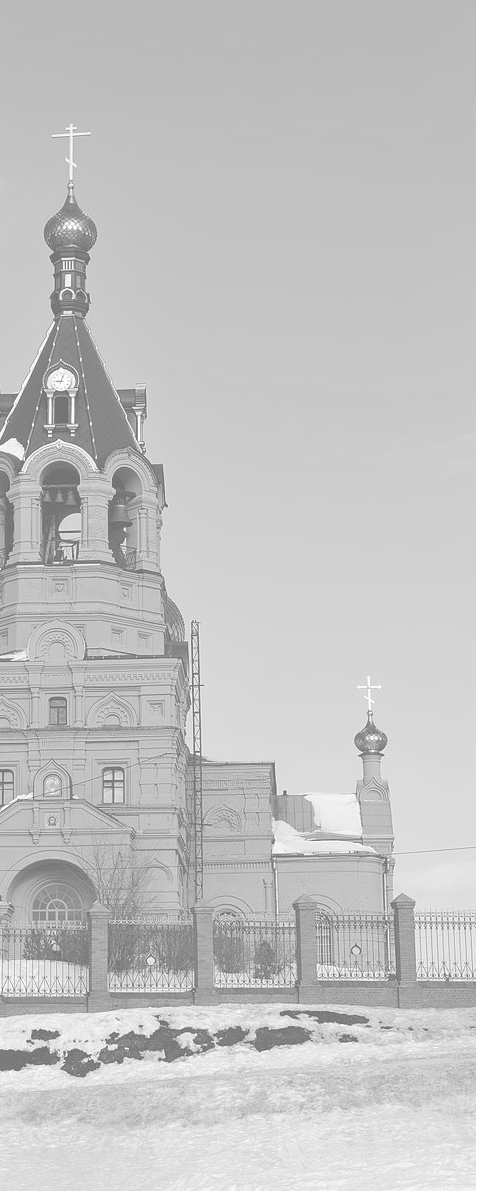

In [17]:
# Load our images
img1 = cv2.imread("B1.png")
img2 = cv2.imread("B2.png")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

cv2_imshow(img1_gray)
cv2_imshow(img2_gray)

In [18]:
orb = cv2.ORB_create(nfeatures=2000)

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

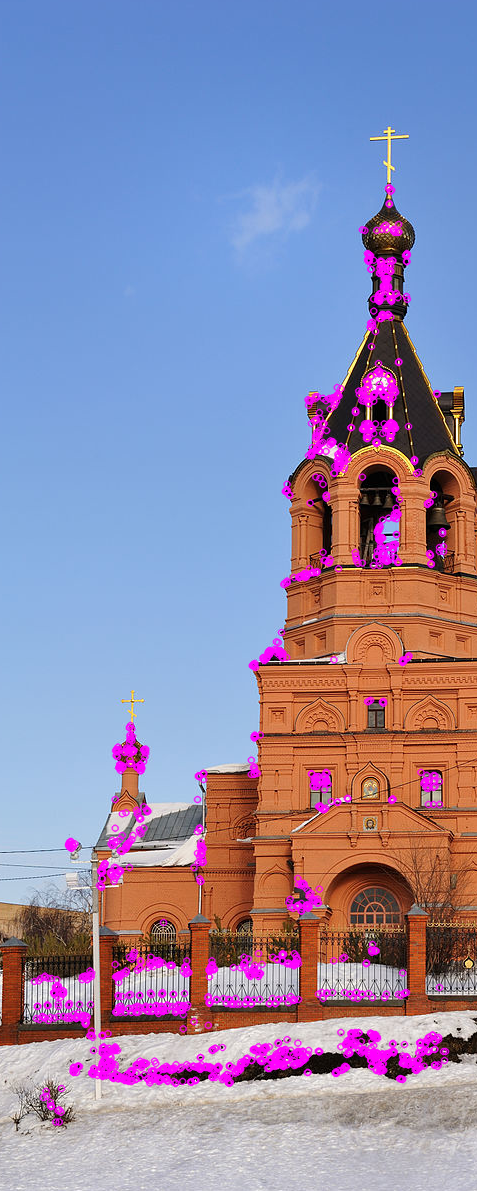

In [20]:
cv2_imshow(cv2.drawKeypoints(img1, keypoints1, None, (255, 0, 255)))


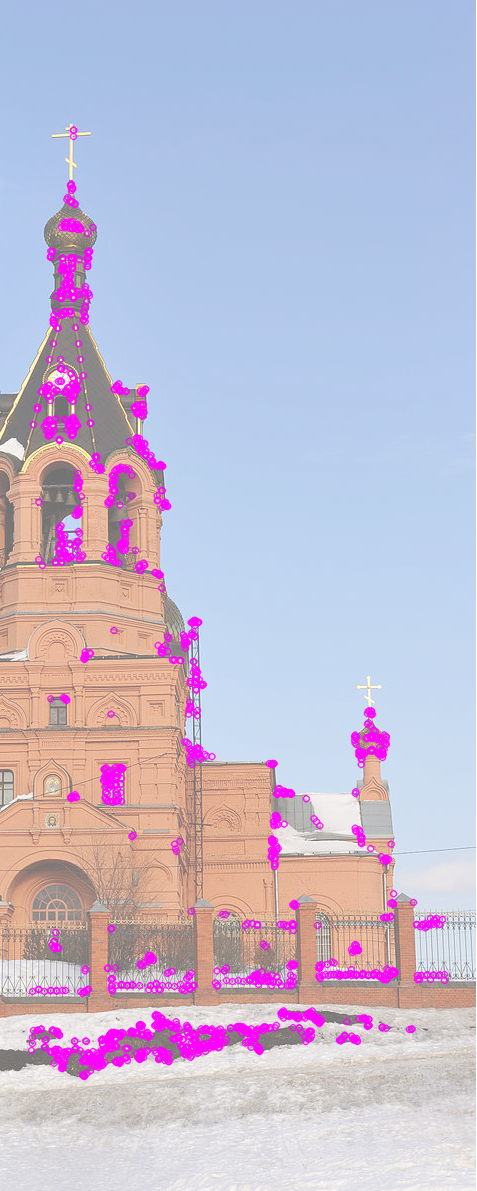

In [21]:
cv2_imshow(cv2.drawKeypoints(img2, keypoints2, None, (255, 0, 255)))


In [22]:
# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2,k=2)

In [23]:
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r, c = img1.shape[:2]
  r1, c1 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
  output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
  output_img[:r, :c, :] = np.dstack([img1, img1, img1])
  output_img[:r1, c:c+c1, :] = np.dstack([img2, img2, img2])

  # Go over all of the matching points and extract them
  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
    cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
    cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

    # Connect the same keypoints
    cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)
    
  return output_img

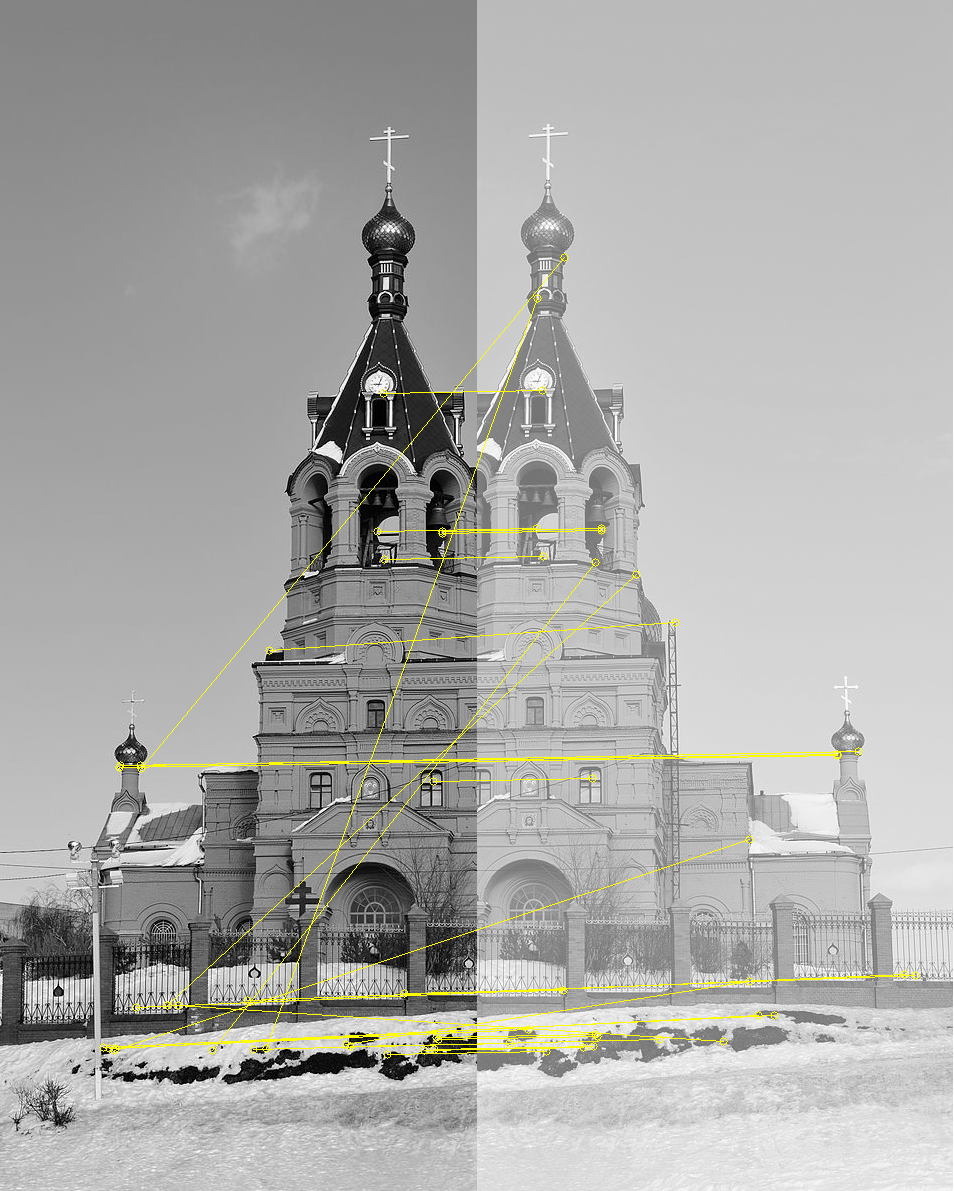

In [24]:
all_matches = []
for m, n in matches:
  all_matches.append(m)

img3 = draw_matches(img1_gray, keypoints1, img2_gray, keypoints2, all_matches[:30])
cv2_imshow(img3)

In [25]:
good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append(m)

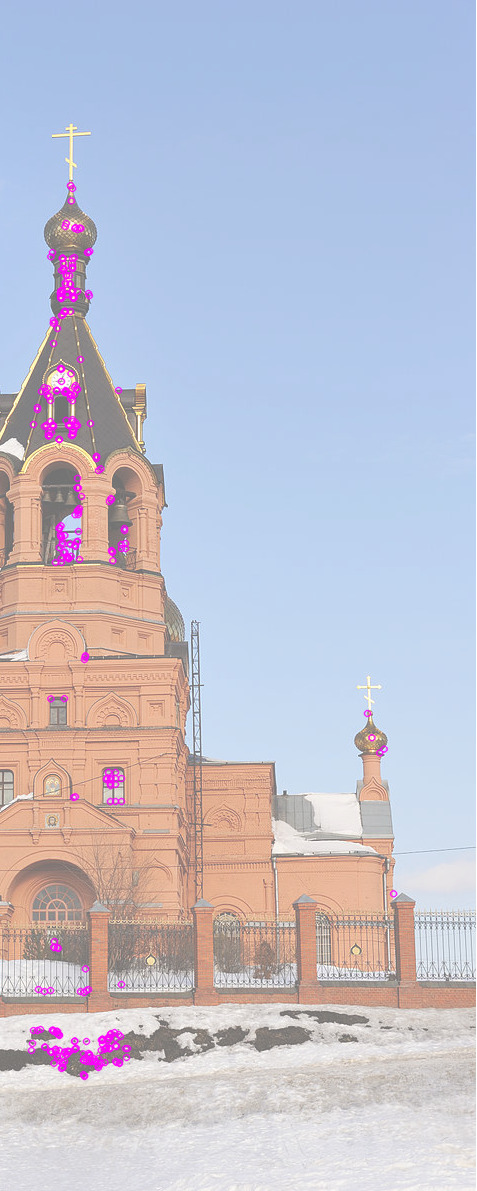

In [26]:
cv2_imshow(cv2.drawKeypoints(img2, [keypoints2[m.trainIdx] for m in good], None, (255, 0, 255)))


In [27]:
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

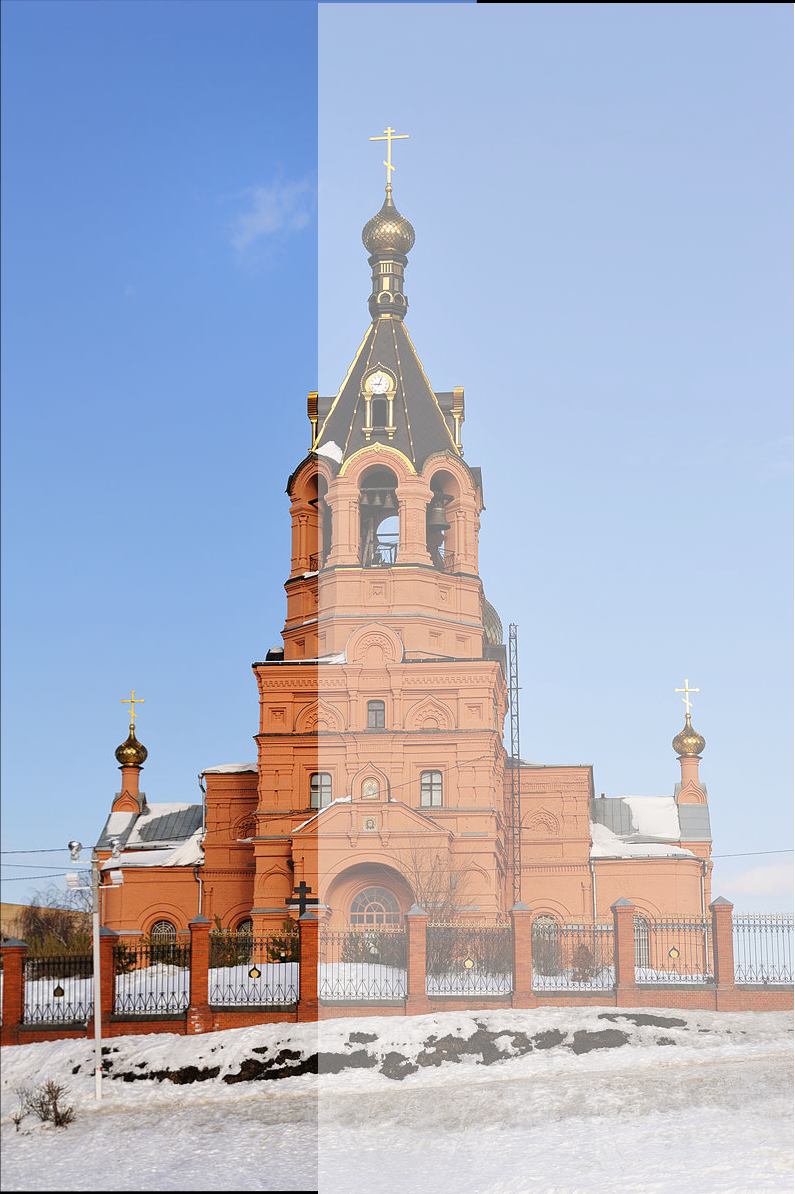

In [28]:
# Set minimum match condition
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    result = warpImages(img2, img1, M)

    cv2_imshow(result)